In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import os
import pandas as pd
pd.options.display.max_columns = 99
import numpy as np
from tqdm.notebook import tqdm
import matplotlib as matlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cp_data = pd.read_parquet('pred_cp_data.parquet')

In [3]:
print(cp_data.shape)
cp_data.head()

(1322102, 19)


,cp_date,service,cp_num,memberId,prob_churn_7days,prob_label,is_visit_next_7days,visit_recency,visit_frequency,avg_visit_cycle,day_since_last_visit,last_visit_device_type,total_prd_page_clicks,avg_prd_page_click,total_page_clicks,avg_page_click,cp_subject,cp_belong_to,cp_positive
0,714,1,1,++IUcF66HZBNEK9iTox9mQ==,0.35,0,1,1.0,9.0,6.8,7.0,1,18.0,2.000,26.0,2.889,0,0,0
1,714,1,1,++QWTgF6HtyWB6Hh8EOqfQ==,0.52,1,0,3.0,11.0,11.9,61.0,1,5.0,0.455,21.0,1.909,0,0,0
2,714,1,1,++cpreJ4gBFRDUb2iI1AnA==,0.67,1,0,53.0,6.0,14.2,29.0,1,0.0,0.000,14.0,2.333,0,0,0
3,714,1,1,++xJHNexPcNcg1MO8juShg==,0.50,1,0,58.0,16.0,4.1,5.0,1,0.0,0.000,18.0,1.125,0,0,0
4,714,1,1,+/BKvoyet+zP4ZWHTiHmEA==,0.93,1,0,48.0,1.0,999.0,999.0,3,0.0,0.000,1.0,1.000,0,0,0


- cp_date: 예측 날짜
- service: 1 - 해외항공 / 2 - 해외여행
- cp_num: 1 - 715 해외항공 / 2 - 715 해외여행 / 3 - 716 해외항공(가격소구&검색조회) / 4 - 720 해외여행
- prob_label: 1 - 이탈 확률 50% 이상 / 0 - 이탈 확률 50% 미만
- avg_prd_page_click: 평균 상품상세 페이지 클릭수
- avg_page_click: 평균 페이지 클릭수
- cp_subject: 1 - 캠페인 모수 o / 0 - 캠페인 모수 x
- cp_belong_to: 1 - 715 해외항공 / 2 - 715 해외여행 / 3 - 716 해외항공(검색조회) / 4 - 716 해외항공(가격소구) / 5 - 720 해외여행 / 6 - 716 캠페인 모수 중복 / 0 - 캠페인 모수 x
- cp_positive: 1 - 캠페인 모수인데 캠페인 유입한 유저 / 2 - 캠페인 모수인데 캠페인에 유입하지 않은 유저 / 0 - 캠페인 모수가 아닌 유저

이탈 예측 성능, 캠페인 요약(캠페인 응답률), 유저 특성 분석(컬럼별 상관관계 등)은 이미 분석이 된 부분이기 때문에 넘어가거나 가볍게 진행함

# 제목 
- 모델의 정확도를 수치 측면에서 산출한다기 보다 "방문하지 않는다고 했는데 실제로 방문한 유저는 어느정도 되는가?"에 초점을 맞춤
- 그리고 그 유저들 중 예측이 틀린 원인이 캠페인인가?(해당 유저 중 캠페인으로 방문한 사람)를 파악
- 이탈예측 대상자 -> 캠페인 대상자(모수) / 전체 방문자 -> 캠페인 대상자 / 전체 방문자 -> 캠페인 대상자&비대상자 비교

## 분석 대상 파악

- 이탈 예측 대상자(1,322,102명) 중 이탈 확률이 50% 이상인 유저는 약 89.35%(1,181,258명)으로, 캠페인 모수는 약 14.96%(197,726명)임.
- 캠페인 모수 모두 이탈 확률이 50% 이상임

In [75]:
print('이탈예측 대상자: ', cp_data.shape[0])
print('이탈예측 대상자 중 이탈확률 50% 이상: ', cp_data.loc[(cp_data['prob_label'] == 1)].shape[0])
print('위 대상자 중 캠패인 모수 O: ', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1)].shape[0])
print('위 대상자 중 캠패인 모수 X: ', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 0)].shape[0])

이탈예측 대상자:  1322102
이탈예측 대상자 중 이탈확률 50% 이상:  1181258
위 대상자 중 캠패인 모수 O:  197726
위 대상자 중 캠패인 모수 X:  983532


In [5]:
print('캠페인모수: ', cp_data.loc[(cp_data['cp_subject'] == 1)].shape[0])
print('캠페인모수(50%이상): ', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] ==  1)].shape[0])
print('캠페인모수(50%이상) 중 반응한 유저: ', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] ==  1) & (cp_data['cp_positive'] == 1)].shape[0])

캠페인모수:  197726
캠페인모수(50%이상):  197726
캠페인모수(50%이상) 중 반응한 유저:  1074


- 캠페인 모수는 기본 조건으로 이탈확률이 50% 이상임.
- 7명이 이탈예측율 50% 미만인데 캠페인에 반응을 했다고 함. 하지만 캠페인 모수에는 해당하지 않기 때문에 수치 상에는 반영이 되지 않음
- 캠페인 모수 중 캠페인에 반응한 유저는 캠페인 모수 중 0.5%(1,074명)임.

In [77]:
print('캠페인모수 & 방문(7일) & 캠페인반응 O:', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 1)].shape[0])
print('캠페인모수 & 방문(14일) & 캠페인반응 O:', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)].shape[0])
print('캠페인모수 & 방문(7일) & 캠페인반응 X:', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 2)].shape[0])
print('캠페인모수 & 방문(14일) & 캠페인반응 X:', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 2)].shape[0])

캠페인모수 & 방문(7일) & 캠페인반응 O: 298
캠페인모수 & 방문(14일) & 캠페인반응 O: 1074
캠페인모수 & 방문(7일) & 캠페인반응 X: 14068
캠페인모수 & 방문(14일) & 캠페인반응 X: 14068


In [74]:
print('캠페인 모수 X:', cp_data.loc[(cp_data['cp_subject'] == 0)].shape[0])
print('캠페인 모수 X(50% 이상):', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 0)].shape[0])
print('캠페인 모수 X & 재방문 O(7일):', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 0) & (cp_data['is_visit_next_7days'] == 1)].shape[0])
print('캠페인 모수 X & 재방문 O(14일):', cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 0) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1))].shape[0])

캠페인 모수 X: 1124376
캠페인 모수 X(50% 이상): 983532
캠페인 모수 X & 재방문 O(7일): 93380
캠페인 모수 X & 재방문 O(14일): 93380


14일 기준점 사용 불가(모델과 캠페인 운영기간이 매칭되지 않아 캠페인 반응률을 하나의 방문 컬럼으로 적용했기 때문에 캠페인 모수가 아닌 경우는 해당 컬럼 값 부재)

In [10]:
cp_data.loc[(cp_data['cp_subject'] == 1)]['prob_label'].value_counts()

1    197726
Name: prob_label, dtype: int64

In [9]:
cp_data.loc[(cp_data['cp_positive'] == 1)]['cp_subject'].value_counts()

1    1074
0       7
Name: cp_subject, dtype: int64

In [7]:
cp_data.loc[(cp_data['cp_subject'] == 1)]['cp_positive'].value_counts()

2    196652
1      1074
Name: cp_positive, dtype: int64

- 캠페인에 반응했는데 캠페인 모수가 아닌 유저는 7명.
- 해당 유저는 이탈확률이 50% 미만이기 때문에 이후 분석 대상에서 제외

In [23]:
print(cp_data.loc[(cp_data['prob_label'] == 0) & (cp_data['cp_positive'] == 1)].shape[0]) # 7명
cp_data.loc[(cp_data['prob_label'] == 0) & (cp_data['cp_positive'] == 1)]

7


,cp_date,service,cp_num,memberId,prob_churn_7days,prob_label,is_visit_next_7days,visit_recency,visit_frequency,avg_visit_cycle,day_since_last_visit,last_visit_device_type,total_prd_page_clicks,avg_prd_page_click,total_page_clicks,avg_page_click,cp_subject,cp_belong_to,cp_positive,avg__page_click
82974,714,1,1,U02sjw4dC/zB0xIgG6Q/xA==,0.44,0,1,0.0,5.0,2.8,4.0,1,0.0,0.000,6.0,1.200,NaN,NaN,1.0,NaN
93217,714,1,1,RetQDVtXPiBUunCNSvht+w==,0.36,0,0,0.0,15.0,8.6,29.0,1,0.0,0.000,32.0,2.133,NaN,NaN,1.0,NaN
166062,714,1,1,uiyy/PcDIlMIPGYCb3qw7g==,0.36,0,1,0.0,3.0,1.5,1.0,1,2.0,0.667,11.0,3.667,NaN,NaN,1.0,NaN
206219,714,1,1,LbyqwWKsCY6OC8h5/obFDQ==,0.42,0,0,0.0,5.0,28.5,37.0,1,13.0,2.600,50.0,10.000,NaN,NaN,1.0,NaN
217883,714,1,1,3NXNhukZiqePLfKH1keO0w==,0.46,0,0,0.0,12.0,13.4,34.0,1,2.0,0.167,17.0,1.417,NaN,NaN,1.0,NaN
257343,714,1,1,Ucut0ixEYwZNfUZO0/M8qQ==,0.46,0,0,0.0,4.0,48.0,10.0,1,0.0,0.000,15.0,3.750,NaN,NaN,1.0,NaN
382637,714,1,1,G9EfGNtmPCqM9UH97GXM6Q==,0.45,0,0,2.0,14.0,10.6,18.0,1,19.0,1.357,112.0,8.000,NaN,NaN,1.0,NaN


- 이탈 확률이 50% 미만 & 캠페인 모수 x & 캠페인에는 반응한 유저
    - 캠페인에 모수일 것이라고 판단하고, 이후 50% 미만인데 캠페인에 반응한 유저에 대한 특성 파악해보는 것도 좋을 듯. 그런데 7명이라(ㅎ) 그냥 버리는 케이스로, 캠페인 모수를 기준으로 작업하면 될 듯

### 요약 01
- 이탈 예측 대상자(1,322,102명) 중 이탈 확률이 50% 이상인 유저는 약 89.35%(1,181,258명)으로, 캠페인 모수는 약 14.96%(197,726명)임.
- 캠페인 모수는 모두 이탈확률 50% 이상임. 50% 미만인 경우도 캠페인에 반응한 사례가 7건 정도있으나, 캠페인 모수에는 체크가 되어있지 않음.
    - 해당 경우는 제외하고 작업
- 이탈 확률 50% 이상인 것을 기준으로 작업 진행 필요.

## 대상: 이탈확률 50% 이상 & 재방문여부

- 이탈 확률이 50% 이상인 유저: 1,181,258명
- 이탈할 것이라 예상했고 방문하지 않은 유저(이탈 확률 50% 이상): 1,073,512명
- 이탈할 것이라고 예상했는데 방문한 유저(이탈 확률 50% 이상): 107,746명

** 위는 7일 이내의 기준. 현재 캠페인 반응률 체크에 대한 기간 범주가 약 2주 이내로 추정. 캠페인 유입 여부를 또 하나의 재방문 컬럼이라고 산정

- 이탈할 것이라고 예상했는데 방문한 유저(이탈 확률 50% 이상 & 재방문 기준 2주 이내): 108,522명

In [11]:
cp_data.loc[(cp_data['prob_label'] == 1)].shape[0]

1181258

In [12]:
cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] == 0)].shape[0]

1073512

In [13]:
cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] == 1)].shape[0]

107746

In [14]:
cp_data.loc[(cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1))].shape[0]

108522

- 이탈할 것이라고 예상했는데 (7일 이내) 방문한 유저 중 캠페인 대상자였던 사람: 14,366명
- 이탈할 것이라고 예상했는데 (7일 이내) 방문한 유저 중 방문 원인이 캠페인인 사람: 298명
- 이탈예상한 유저 중 캠페인에 반응을 보인 유저(기간 14일 이내): 1,074명

!! 캠페인 모수 추출 시 재방문 컬럼과 시점 매칭 필요 -> 시점 기준이 2개인 것: 7일 이내, 14주 이내(캠페인 실행 시점에 따라 상이)
- 재방문 기준이 7일이기 때문에 7일을 가져가되, 캠페인 positive를 하나의 방문으로 가정하고 재설정
- 브레이즈 데이터 추출 시점이 7일 이후였기 때문에 매칭이 안되는 부분이 있음. 7일 이내, 14일 이내로 구분 짓고 판단 진행.(추출한 시점이 7월 28일 ~ 8월 1일로 추정. 약 2주 이내로 판단됨.)
- 모델의 정확도는 재방문 컬럼이 1로 잡힌 유저 중 캠페인에 반응한 유저로 한정될 필요 있음.

In [15]:
cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_subject'] == 1)].shape[0]

14366

In [17]:
cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_subject'] == 1) & (cp_data['cp_positive'] == 1)].shape[0]

298

In [18]:
cp_data.loc[(cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_subject'] == 1)].shape[0]

15142

In [19]:
cp_data.loc[(cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_subject'] == 1) & (cp_data['cp_positive'] == 1)].shape[0]

1074

In [20]:
cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)][['cp_num','is_visit_next_7days']].value_counts().sort_index()

cp_num  is_visit_next_7days
1       0                      219
        1                       57
2       0                       55
        1                      164
3       0                      239
        1                       55
4       0                      263
        1                       22
dtype: int64

### 요약 02
- 이탈 확률이 50% 이상인 유저: 1,181,258명
- 이탈할 것이라 예상했고 방문하지 않은 유저(이탈 확률 50% 이상): 1,073,512명(약 90.88%)
- 이탈할 것이라고 예상했는데 방문한 유저(이탈 확률 50% 이상 & 재방문 기준 1주 이내, 이하 A그룹): 107,746명(약 9.12%)
- 이탈할 것이라고 예상했는데 방문한 유저(이탈 확률 50% 이상 & 재방문 기준 2주 이내, 이하 B그룹): 108,522명(약 9.19%)

** 모델이 예측하지 못한 방문 유저 중 유입 원인이 캠페인인가?

- 이탈할 것이라고 예상했는데 (7일 이내) 방문한 유저 중 캠페인 대상자였던 사람(이하 모수A): 14,366명
- 이탈할 것이라고 예상했는데 (14일 이내) 방문한 유저 중 캠페인 대상자였던 사람(이하 모수B): 15,142명
    - A그룹 중 13.33%가 캠페인 모수였음
    - B그룹 중 13.95%가 캠페인 모수였음
- (A그룹) 7일이내 방문한 고객 중 캠페인에 반응한 유저: 298명
- (B그룹) (브레이즈 추출 시점 - 실행 후 2주 내로 추정) 캠페인 운영 기간 내에 반응한 유저: 1,074명
    - A그룹 중 약 0.28%의 유저가 캠페인으로 방문함.(재방문 = 7일 이내)
    - B그룹 중 약 0.99%의 유저가 캠페인으로 방문함. 
    - 모수A 중 캠페인에 반응한 유저는 약 2.07%임
    - 모수B 중 캠페인에 반응한 유저는 약 7.09%임
    
- 캠페인 메세지를 받았을 때 약 27.7%가 7일 내에 반응을 했으나, 그 외는 반응하는 데 시간이 좀 더 소요됨.
- 캠페인 모수 중 평균 4.58% 정도가 실제로 유입이 되었으며, 재방문 범주가 넓을 수록 더 많이 반응하는 것으로 보임.
    - 유입된 일자를 알 수 있다면, 평균적으로 언제 캠페인에 반응을 하는 지 알 수 있을까?
    - 그렇다면 이후 실험을 할 때 어느정도 기간을 두고 유저의 반응을 보고 분석을 할 지 기준점이 생기지 않을까?

- 이후 데이터 매핑 시 추출 시점을 맞춰서 하던가 기준을 설정할 필요가 있을 듯. ex. 캠페인 운영 기간 2주 -> 2주간의 데이터 추출    

# 캠페인 반응률

- 'avg_prd_page_click', 'avg_page_click' 수정으로 인해 다시 불러왔지만 위에서 해당 컬럼 사용하지 않았기에 분석 내용 유지

In [2]:
cp_data = pd.read_parquet('pred_cp_data.parquet')

비교군별 분석: 실행 캠페인별, 채널별, 컨텐츠 유형별
캠페인(5개)별에 대한 반응률
사용 채널별 반응률(앱푸시 vs 카톡플친): 전체 / 서비스별
캠페인 컨텐츠 유형별 반응률(가격소구 vs 검색행동): 7/16자로만 비교

- 캠페인 모수

In [25]:
pv_pop = pd.pivot_table(data=cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1)], index='cp_num', values='memberId', aggfunc='count', fill_value=0).reset_index().rename(columns={'memberId':'cp_resp'})

In [26]:
pv_pop

,cp_num,cp_resp
0,1,77637
1,2,49468
2,3,43746
3,4,26875


- 캠페인 반응 유저로 데이터 한정

In [3]:
cp_7d = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 1)]
cp_14d = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]

- 캠페인 반응 유저

In [328]:
pv_data7 = pd.pivot_table(data=cp_7d, index='cp_num', values='memberId', aggfunc='count', fill_value=0).reset_index()
pv_data14= pd.pivot_table(data=cp_14d, index='cp_num', values='memberId', aggfunc='count', fill_value=0).reset_index()

In [329]:
pv_data = pd.merge(pv_data7, pv_data14, on='cp_num').rename(columns={'memberId_x':'7d', 'memberId_y':'14d'})

In [401]:
pv_data

,cp_num,7d,14d
0,1,57,276
1,2,164,219
2,3,55,294
3,4,22,285


## 캠페인 모수 대비 반응률

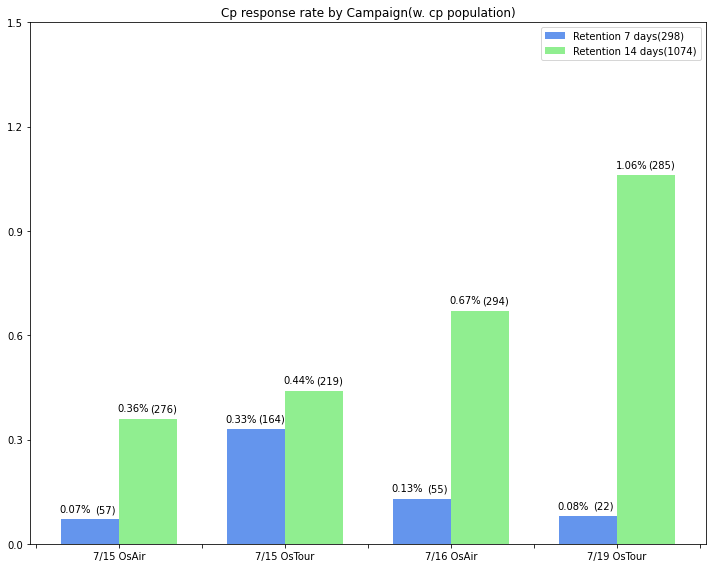

In [457]:
# label_list = [f"cp{i+1}" for i in range(len(pv_data.cp_num))]
label_list = ['7/15 OsAir', '7/15 OsTour', '7/16 OsAir', '7/19 OsTour']
x = np.arange(len(pv_data.cp_num))
y = list(map(lambda x: '('+str(x)+')', pv_data['7d'].tolist() + pv_data['14d'].tolist()))
y_int = list(map(lambda x: round(x*100, 2), np.divide(pv_data['7d'].tolist(), pv_pop['cp_resp'].tolist())))
y_per = list(map(lambda x: str(round(x*100, 2))+'%', np.divide(pv_data['7d'].tolist(), pv_pop['cp_resp'].tolist())))+list(map(lambda x: str(round(x*100, 2))+'%', np.divide(pv_data['14d'].tolist(), pv_pop['cp_resp'].tolist())))
# 캠페인 모수 중 반응한 비율


width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))

plt1 = ax.bar(x - width/2, list(map(lambda x: round(x*100, 2), np.divide(pv_data['7d'].tolist(), pv_pop['cp_resp'].tolist()))), width, label='Retention 7 days(298)', color = 'cornflowerblue')
plt2 = ax.bar(x + width/2, list(map(lambda x: round(x*100, 2), np.divide(pv_data['14d'].tolist(), pv_pop['cp_resp'].tolist()))), width, label='Retention 14 days(1074)', color = 'lightgreen')

ax.set_title('Cp response rate by Campaign(w. cp population)')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = label_list[0]
labels[4] = label_list[1]
labels[6] = label_list[2]
labels[8] = label_list[3]
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0, y_int[-1]+1.5, 0.3))
           
ax.legend()

rects = ax.patches

for rect, label1, label2 in zip(rects, y_per, y):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 4, height + 0.015, label1, ha="center", va="bottom"
    )
    ax.text(
        rect.get_x() + rect.get_width() / 1.3, height + 0.015, label2, ha="center", va="bottom"
    )


fig.tight_layout()

plt.show()

## 캠페인 반응유저 내 반응률

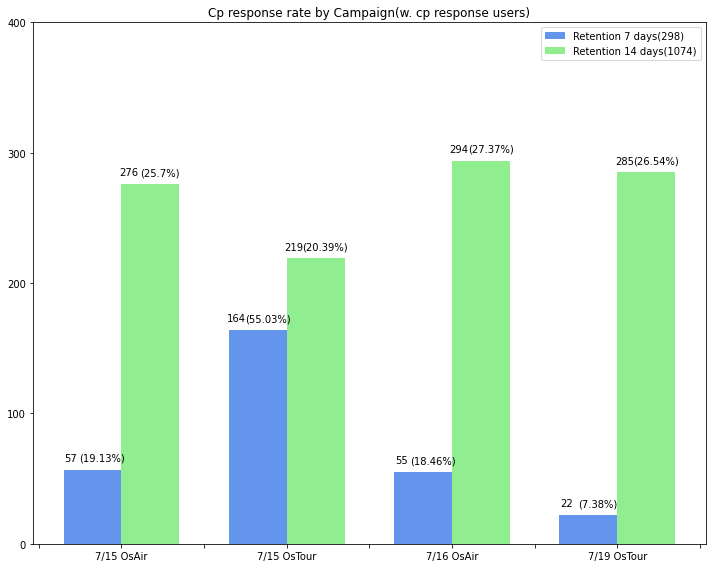

In [459]:
# label_list = [f"cp{i+1}" for i in range(len(pv_data.cp_num))]
label_list = ['7/15 OsAir', '7/15 OsTour', '7/16 OsAir', '7/19 OsTour']
x = np.arange(len(pv_data.cp_num))
y = pv_data['7d'].tolist() + pv_data['14d'].tolist()
y_per = list(map(lambda x: '('+str(round(x/len(cp_7d)*100, 2))+'%)', pv_data['7d'].tolist()))+list(map(lambda x: '('+str(round(x/len(cp_14d)*100, 2))+'%)', pv_data['14d'].tolist()))
# 위는 반응한 사람 중에서 얼만큼의 비율을 차지 하는 지


width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))

plt1 = ax.bar(x - width/2, pv_data['7d'], width, label='Retention 7 days(298)', color = 'cornflowerblue')
plt2 = ax.bar(x + width/2, pv_data['14d'], width, label='Retention 14 days(1074)', color = 'lightgreen')

ax.set_title('Cp response rate by Campaign(w. cp response users)')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = label_list[0]
labels[4] = label_list[1]
labels[6] = label_list[2]
labels[8] = label_list[3]
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0, y[-1]+200, 100))
           
ax.legend()

rects = ax.patches

for rect, label1, label2 in zip(rects, y, y_per):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 8, height + 5, label1, ha="center", va="bottom"
    )
    ax.text(
        rect.get_x() + rect.get_width() / 1.5, height + 5, label2, ha="center", va="bottom"
    )


fig.tight_layout()

plt.show()

- 다른 일자별로 진행하는 캠페인 상 이후에 추출할 수록 먼저 진행한 캠페인의 유입이 많아질 수 밖에 없음(그걸 가능성이 더 높음). 따라서 제일 마지막에 진행한 7/19 자 캠페인의 유입 수치가 가장 낮음(감안할 필요 있음)
- [7일] 7/15(동일한 일자에 진행한 캠페인) 캠페인 확인 시 해외여행이 해외항공보다 더 높은 유입 수치를 보여줬으며, 7일 내 반응 유저 중에서도 55% 이상의 반응률을 보임.
- 하지만 시간이 길어지면서 해외항공 관련 캠페인의 유입률이 n% 상승하여, 해외여행보다 해외항공의 반응률이 더 높아짐. 해외항공은 7일 이후에 반응이 급격하게 나타남. 해외항공 관련 캠페인을 진행할 시 7일보다 더 기간을 잡아서 진행할 필요성이 있을 듯.
- [14일] 19일 캠페인은 가장 짧은 캠페인 운영 시간을 가졌음에도 반응률이 2번째로 높음. 가장 높은 16일 캠페인 또한 19cp와 동일하게 "가격소구"에 초점을 맞추고 있음. >> 가격 소구 포인트에 집중할 필요가 있을 듯

> 푸시를 보낸 후 7일 이내 접속한 유저: 해외항공 < 해외여행
> 푸시를 보낸 후 14일 이내 접속한 유저: 해외항공 > 해외여행
 => 특정 조건없이 어떤 서비스에 유저가 더 빠르게 반응한다라기 보다, 해외여행에 니즈가 있는 유저는 비교적 단 기간에 유입되는 비율이 높았으며 해외항공에 니즈가 있는 유저는 푸시를 받은 지 7일 이후에 유입되는 비율이 높았음.
 * 따라서 서비스별로 유저의 반응 속도에 차이가 있기 때문에 이를 감안하여 운영기간을 설정하는 것이 더 정확한 분석과 성과 측정이 가능할 것으로 산정됨.

### 캠페인 컨텐츠 유형별 반응률: 가격소구 VS 검색행동

- 캠페인 세부 분류: 일자, 서비스, 컨텐츠
- 4번 확인 시 4+6 / 5 확인 시 5+6

In [27]:
pv_pop = pd.pivot_table(data=cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1)], index='cp_belong_to', values='memberId', aggfunc='count', fill_value=0).reset_index().rename(columns={'memberId':'cp_resp'})

In [28]:
pv_pop

,cp_belong_to,cp_resp
0,1,77637
1,2,49468
2,3,9079
3,4,34650
4,5,26875
5,6,17


In [29]:
pv_pop.loc[2, 'cp_resp'] = pv_pop.iloc[2]['cp_resp'] + pv_pop.iloc[5]['cp_resp']
pv_pop.loc[3, 'cp_resp'] = pv_pop.iloc[3]['cp_resp'] + pv_pop.iloc[5]['cp_resp']

In [30]:
pv_pop

,cp_belong_to,cp_resp
0,1,77637
1,2,49468
2,3,9096
3,4,34667
4,5,26875
5,6,17


In [35]:
pv_pop.iloc[2]['cp_resp']

9096

In [4]:
cp_7d.head()

,cp_date,service,cp_num,memberId,prob_churn_7days,prob_label,is_visit_next_7days,visit_recency,visit_frequency,avg_visit_cycle,day_since_last_visit,last_visit_device_type,total_prd_page_clicks,avg_prd_page_click,total_page_clicks,avg_page_click,cp_subject,cp_belong_to,cp_positive
5489,714,1,1,JdmmNMMTyuSCHHbHaFyMCw==,0.66,1,1,8.0,7.0,10.3,33.0,1,32.0,4.571,48.0,6.857,1,1,1
11265,714,1,1,gnmmjvZxJPjNZBf4odHoQQ==,0.59,1,1,1.0,4.0,24.3,1.0,3,3.0,0.750,28.0,7.000,1,1,1
11454,714,1,1,hX17+I+HmWYxHzr6OtUMAQ==,0.76,1,1,6.0,2.0,14.0,14.0,1,0.0,0.000,3.0,1.500,1,1,1
34554,714,1,1,7xWjNOWopKvvxmodVC4VQg==,0.82,1,1,58.0,1.0,999.0,999.0,1,2.0,2.000,14.0,14.000,1,1,1
36984,714,1,1,HUlb7YMOiSWI6sFASMwqvA==,0.74,1,1,53.0,3.0,22.0,20.0,1,0.0,0.000,10.0,3.333,1,1,1


In [5]:
pv_data7 = pd.pivot_table(data=cp_7d, index='cp_belong_to', values='memberId', aggfunc='count', fill_value=0).reset_index()
pv_data14= pd.pivot_table(data=cp_14d, index='cp_belong_to', values='memberId', aggfunc='count', fill_value=0).reset_index()

In [6]:
pv_data = pd.merge(pv_data7, pv_data14, on='cp_belong_to').rename(columns={'memberId_x':'7d', 'memberId_y':'14d'})

In [7]:
pv_data

,cp_belong_to,7d,14d
0,1,57,276
1,2,164,219
2,3,16,63
3,4,37,228
4,5,22,285
5,6,2,3


- 3+6, 4+6으로 테이블 따로 만들어서 진행. 캠페인 반응률 확인

In [8]:
pv_data.loc[2, '7d'] = pv_data.iloc[2]['7d'] + pv_data.iloc[5]['7d']
pv_data.loc[2, '14d'] = pv_data.iloc[2]['14d'] + pv_data.iloc[5]['14d']
pv_data.loc[3, '7d'] = pv_data.iloc[3]['7d'] + pv_data.iloc[5]['7d']
pv_data.loc[3, '14d'] = pv_data.iloc[3]['14d'] + pv_data.iloc[5]['14d']

In [9]:
pv_data = pv_data.loc[2:3]

In [10]:
pv_data

,cp_belong_to,7d,14d
2,3,18,66
3,4,39,231


In [19]:
    data = list(pv_data['7d'].tolist() + pv_data['14d'].tolist())
    y_int[0]

[18, 39, 66, 231]

In [67]:
print('serch:', pv_pop.iloc[2]['cp_resp'])
print('price:', pv_pop.iloc[3]['cp_resp'])

serch: 9096
price: 34667


In [79]:
y_per_int

[0.2, 0.11, 0.73, 0.67]

In [84]:
[y_per_int[0], y_per_int[1]]

[0.2, 0.11]

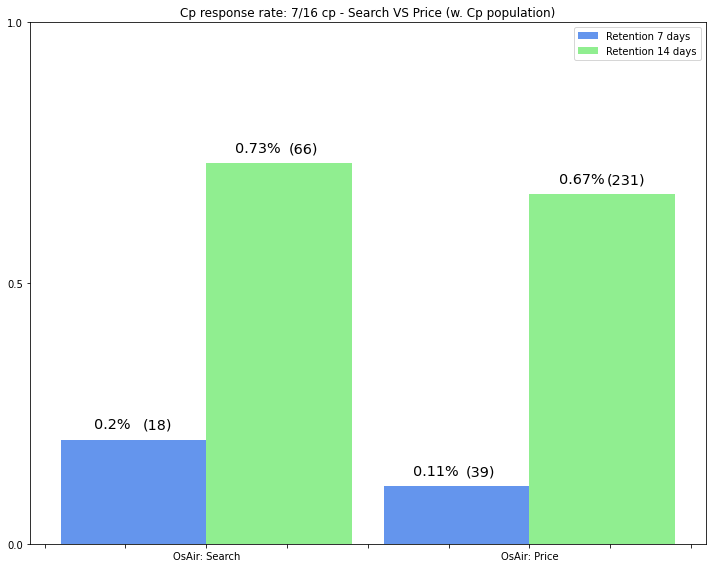

In [128]:
# label_list = [f"cp{i+1}" for i in range(len(pv_data.cp_num))]
label_list = ['OsAir: Search', 'OsAir: Price']
x = np.arange(len(pv_data.cp_belong_to))
y = list(map(lambda x: '('+str(x)+')', pv_data['7d'].tolist() + pv_data['14d'].tolist()))
y_int = list(pv_data['7d'].tolist() + pv_data['14d'].tolist())
y_per_int = []
y_per_int.append(round(y_int[0] / pv_pop.iloc[2]['cp_resp'] *100, 2))
y_per_int.append(round(y_int[1] / pv_pop.iloc[3]['cp_resp'] *100, 2))
y_per_int.append(round(y_int[2] / pv_pop.iloc[2]['cp_resp'] *100, 2))
y_per_int.append(round(y_int[3] / pv_pop.iloc[3]['cp_resp'] *100, 2))
y_per = []
y_per.append(str(round(y_int[0] / pv_pop.iloc[2]['cp_resp'] *100, 2))+'%')
y_per.append(str(round(y_int[1] / pv_pop.iloc[3]['cp_resp'] *100, 2))+'%')
y_per.append(str(round(y_int[2] / pv_pop.iloc[2]['cp_resp'] *100, 2))+'%')
y_per.append(str(round(y_int[3] / pv_pop.iloc[3]['cp_resp'] *100, 2))+'%')


width = 0.45

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))

plt1 = ax.bar(x - width/2, [y_per_int[0], y_per_int[1]], width, label='Retention 7 days', color = 'cornflowerblue')
plt2 = ax.bar(x + width/2, [y_per_int[2], y_per_int[3]], width, label='Retention 14 days', color = 'lightgreen')

ax.set_title('Cp response rate: 7/16 cp - Search VS Price (w. Cp population)')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[3] = label_list[0]
labels[7] = label_list[1]
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0, y_per_int[-1]+0.5, 0.5))
           
ax.legend()

rects = ax.patches

for rect, label1, label2 in zip(rects, y_per, y):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2.8, height + 0.015, label1, ha="center", va="bottom", size = 'x-large'
    )
    ax.text(
        rect.get_x() + rect.get_width() / 1.5, height + 0.015, label2, ha="center", va="bottom", size = 'x-large'
    )



fig.tight_layout()

plt.show()

- 7/16 캠페인 모수 내 컨텐츠 모수별 비율
- 검색 조회 모수는 9066, 가격소구 모수는 34667으로 약 3.8배 차이가 남.
- 모수 대비 반응률을 확인했을 때, 검색 조회 캠페인에 대한 반응률이 더 높게 나옴. 하지만 수치 상으로 7일 기준 약 2배, 14일 기준 3.5배로 큰 차이가 있음.

serch: 9096
price: 34667

- 캠페인 반응 유저 대비 비율

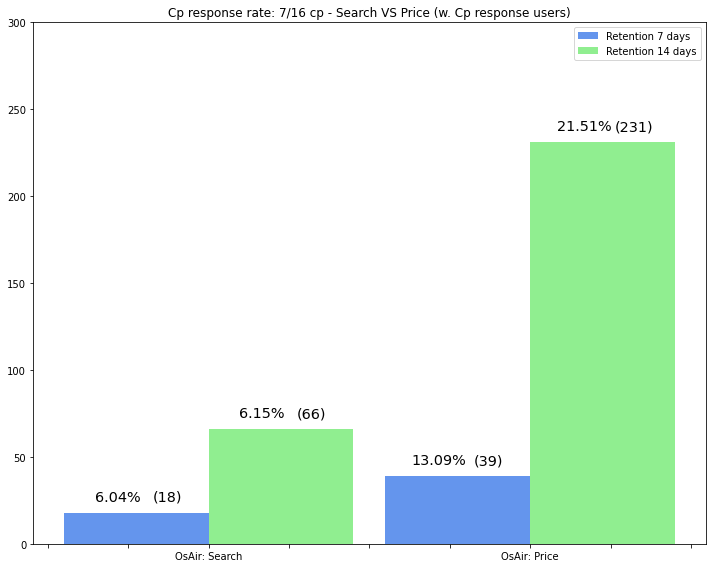

In [129]:
# label_list = [f"cp{i+1}" for i in range(len(pv_data.cp_num))]
label_list = ['OsAir: Search', 'OsAir: Price']
x = np.arange(len(pv_data.cp_belong_to))
y = list(map(lambda x: '('+str(x)+')', pv_data['7d'].tolist() + pv_data['14d'].tolist()))
y_int = list(pv_data['7d'].tolist() + pv_data['14d'].tolist())
y_per_int = []
y_per_int.append(round(y_int[0] / len(cp_7d) *100, 2))
y_per_int.append(round(y_int[1] / len(cp_7d) *100, 2))
y_per_int.append(round(y_int[2] / len(cp_14d) *100, 2))
y_per_int.append(round(y_int[3] / len(cp_14d) *100, 2))
y_per = []
y_per.append(str(round(y_int[0] / len(cp_7d) *100, 2))+'%')
y_per.append(str(round(y_int[1] / len(cp_7d) *100, 2))+'%')
y_per.append(str(round(y_int[2] / len(cp_14d) *100, 2))+'%')
y_per.append(str(round(y_int[3] / len(cp_14d) *100, 2))+'%')


width = 0.45

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))

plt1 = ax.bar(x - width/2, pv_data['7d'], width, label='Retention 7 days', color = 'cornflowerblue')
plt2 = ax.bar(x + width/2, pv_data['14d'], width, label='Retention 14 days', color = 'lightgreen')

ax.set_title('Cp response rate: 7/16 cp - Search VS Price (w. Cp response users)')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[3] = label_list[0]
labels[7] = label_list[1]
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0, y_int[-1]+100, 50))
           
ax.legend()

rects = ax.patches

for rect, label1, label2 in zip(rects, y_per, y):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2.7, height + 5, label1, ha="center", va="bottom", size = 'x-large'
    )
    ax.text(
        rect.get_x() + rect.get_width() / 1.4, height + 5, label2, ha="center", va="bottom", size = 'x-large'
    )



fig.tight_layout()

plt.show()

- 캠페인 반응 유저 대비 반응률
- 반응 유저 내에서는 가격소구가 기간 상관없이 높은 반응률을 보임.

캠페인 모수가 3배 이상 차이가 나기 때문에 해당 부분은 감안할 필요가 있겠으나, 실 유저 수치와 반응한 유저들의 유입 컨텐츠를 확인했을 때 가격소구에 집중하는 것이 더 좋은 성과가 있을 것이라 판단됨.

# 이탈율 분포 비교

## 이탈율 분포: 캠페인 모수(재방문 7일, 14일)
- 캠페인 모수 전체의 이탈율 분포
- 캠페인 모수 중 방문을 했지만, 캠페인이 원인이 아닌 경우도 있기 때문에 전체적으로 확인

[Text(0.5, 1.0, 'Cp subject: retention 14days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

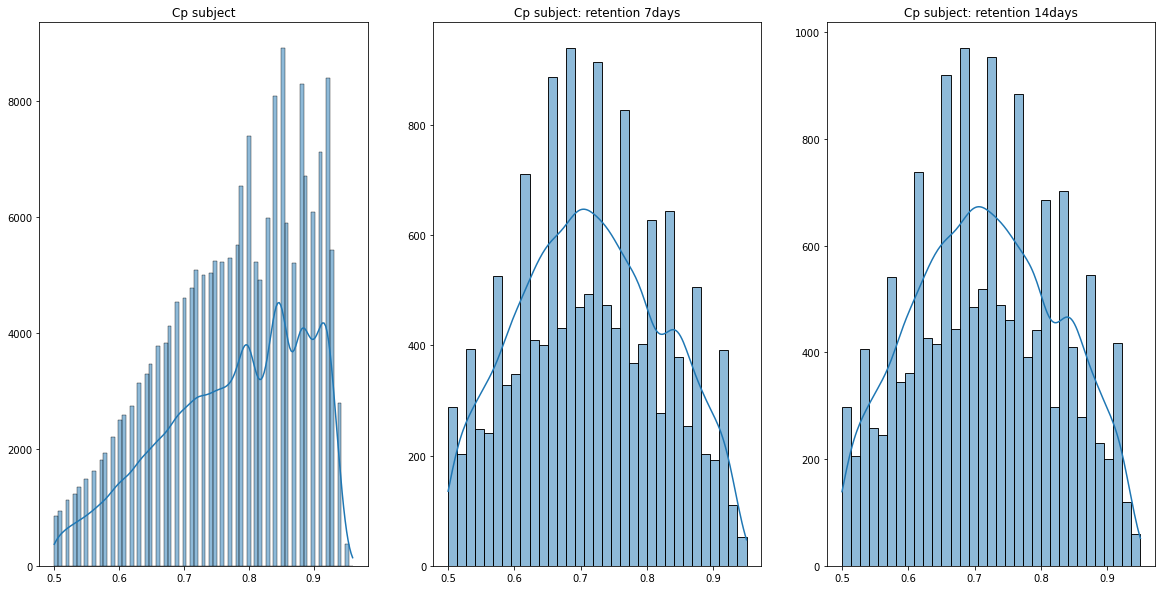

In [30]:
# 캠페인 모수는 모두 이탈율 50% 이상

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((20, 10))

fig0 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] ==  1)]['prob_churn_7days'] , kde = True, ax = axes[0])
fig0.set(title = 'Cp subject', xlabel = '', ylabel = '')
fig1 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] ==  1) & (cp_data['is_visit_next_7days'] ==  1) ]['prob_churn_7days'] , kde = True, ax = axes[1])
fig1.set(title = 'Cp subject: retention 7days', xlabel = '', ylabel = '')
fig2 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1))]['prob_churn_7days'], kde = True, ax = axes[2])
fig2.set(title = 'Cp subject: retention 14days', xlabel = '', ylabel = '')

[Text(0.5, 1.0, 'Cp subject'), Text(0.5, 0, ''), Text(0, 0.5, '')]

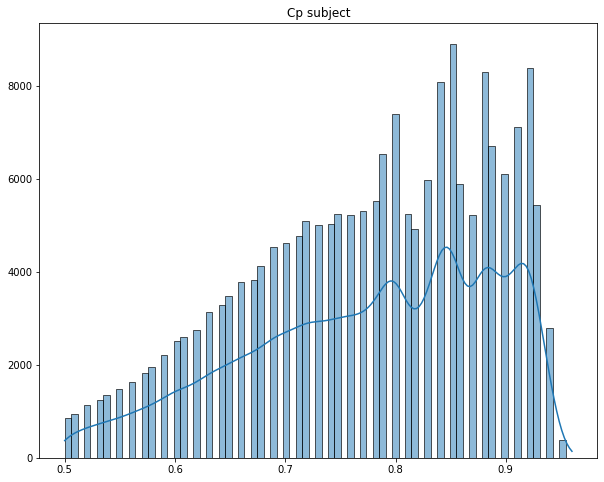

In [256]:
# 캠페인 모수는 모두 이탈율 50% 이상

fig, axes = plt.subplots(1, 1)
fig.set_size_inches((10, 8))

fig0 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] ==  1)]['prob_churn_7days'] , kde = True)
fig0.set(title = 'Cp subject', xlabel = '', ylabel = '')

- 캠페인 모수의 이탈율은 70% 초반 이후가 높은 비율을 차지. 그중 8-90%의 파이가 큼
- 하지만 8-90% 이탈율을 가진 유저는 실 규모 대비 실제 재방문하는 비율은 낮았음.
- 실제로 이탈율 70% 전후가 캠페인 모수로서도, 실제 재방문 유저로서도 높은 비율을 차지함.
- 애초에 캠페인 모수 중 50% 대인 유저는 적은 비율을 차지하긴 하는 상황. 이 부분이 캠페인 모수 자체로 인해 위와 같이 나타나는 것인지, 아니면 이탈율이 50 ~ 80% 사이에서 다른 변수로 인해 예측과 달리 방문이 일어나는 건지 파악해야 함.

** 실제로 이탈율 50%인 유저가 방문하는 비율이 낮았을까? 모수가 적어서 위와 같이 보인 게 아닐까?

50%

In [40]:
cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6))]['memberId'].count()

14603

In [41]:
cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()

2227

In [43]:
(cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6))]['memberId'].count()) *100

15.250291036088475

70%

In [45]:
cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8))]['memberId'].count()

52325

In [46]:
cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()

4376

In [47]:
(cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8))]['memberId'].count()) * 100 

8.36311514572384

- 50 ~ 90% 까지의 모수 대비 재방문 비율 확인

In [52]:
print('50%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6))]['memberId'].count()) *100, 2))
print('60%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7))]['memberId'].count()) *100, 2))
print('70%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8))]['memberId'].count()) *100, 2))
print('80%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9))]['memberId'].count()) *100, 2))
print('90%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1)) & (cp_data['is_visit_next_7days'] ==  1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1))]['memberId'].count()) *100, 2))

50%: 15.25
60%: 12.15
70%: 8.36
80%: 4.34
90%: 2.47


[Text(0.5, 1.0, 'Cp subject: retention 14days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

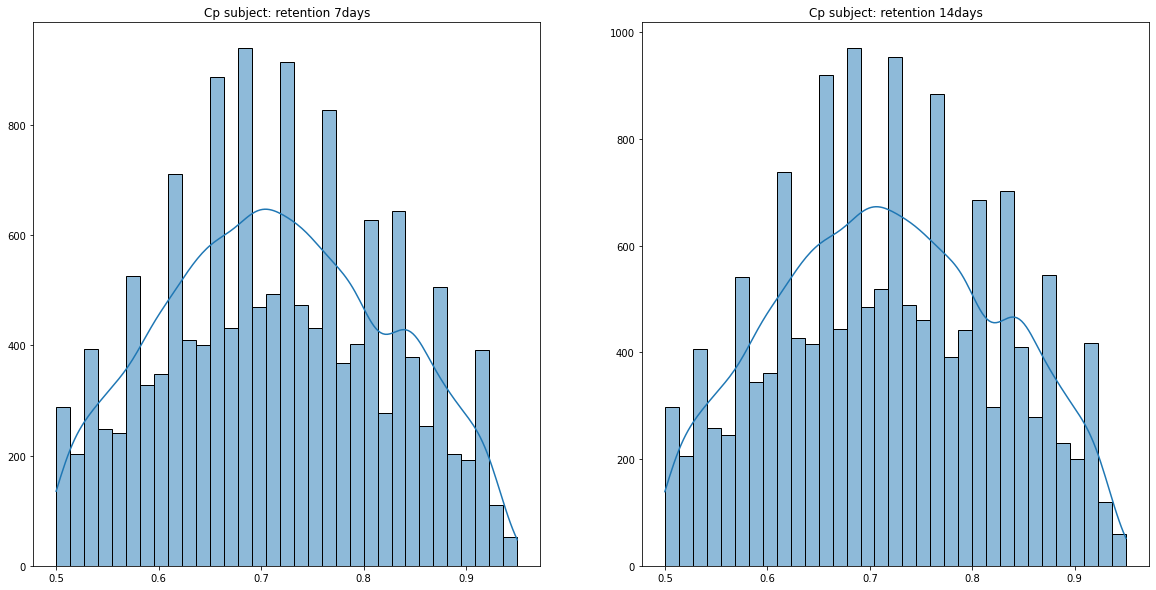

In [33]:
# 캠페인 모수는 모두 이탈율 50% 이상

fig, axes = plt.subplots(1, 2)
fig.set_size_inches((20, 10))

fig1 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] ==  1) & (cp_data['is_visit_next_7days'] ==  1) ]['prob_churn_7days'] , kde = True, ax = axes[0])
fig1.set(title = 'Cp subject: retention 7days', xlabel = '', ylabel = '')
fig2 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1))]['prob_churn_7days'], kde = True, ax = axes[1])
fig2.set(title = 'Cp subject: retention 14days', xlabel = '', ylabel = '')

[Text(0.5, 1.0, 'Cp subject: retention 7days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

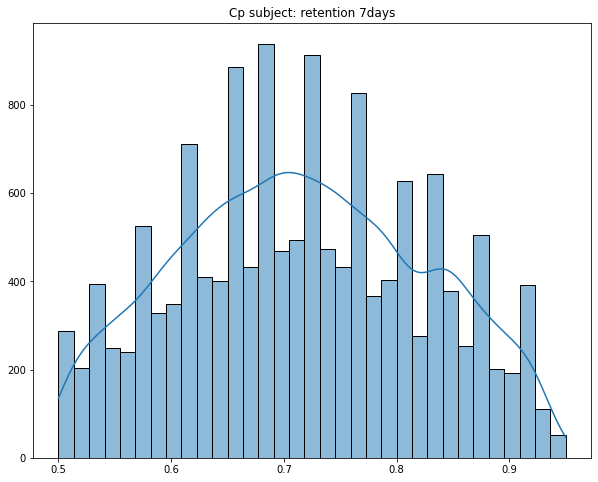

In [255]:
# 캠페인 모수는 모두 이탈율 50% 이상

fig, axes = plt.subplots(1, 1)
fig.set_size_inches((10, 8))

fig1 = sns.histplot(cp_data.loc[(cp_data['cp_subject'] ==  1) & (cp_data['is_visit_next_7days'] ==  1) ]['prob_churn_7days'] , kde = True)
fig1.set(title = 'Cp subject: retention 7days', xlabel = '', ylabel = '')

- 캠페인 모수에서 재방문 일자에 따른 이탈율 분포 차이는 크지 않는 것으로 판단됨

## 이탈율 분포: 캠페인 반응 유저(재방문 7일, 14일)

Text(0.5, 1.0, 'Churn: retention 14days')

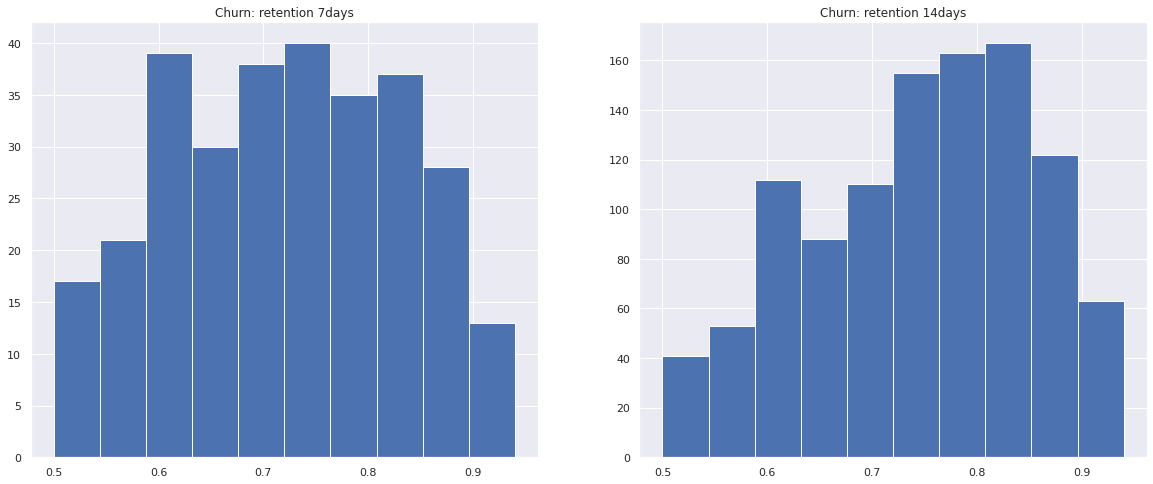

In [145]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches((20, 8))

axes[0].hist(cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[0].set_title('Cp positive: retention 7days')

axes[1].hist(cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[1].set_title('Cp positive: retention 14days')

[Text(0.5, 1.0, 'Cp positive: retention 14days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

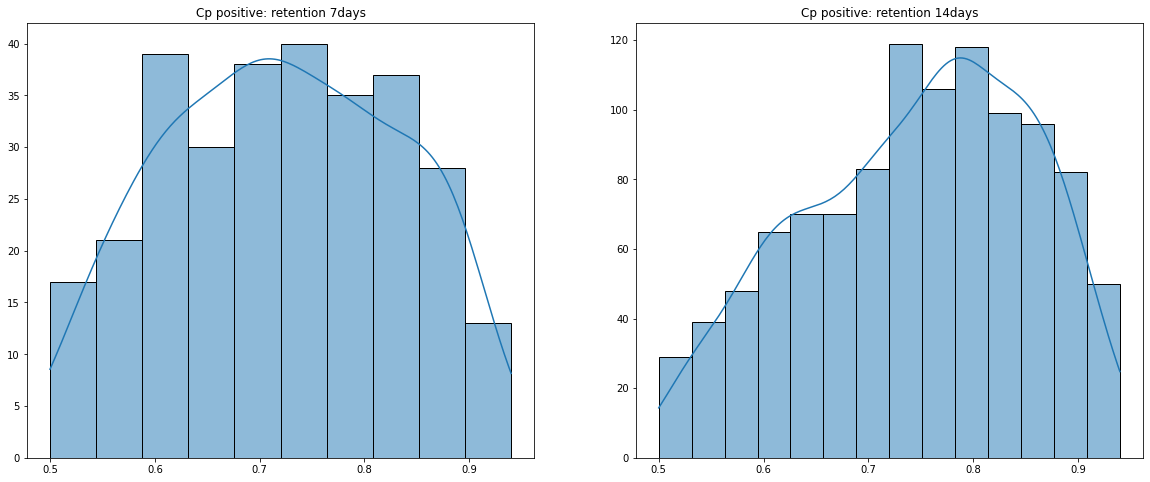

In [60]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches((20, 8))

fig1 = sns.histplot(cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True, ax = axes[0])
fig1.set(title = 'Cp positive: retention 7days', xlabel = '', ylabel = '')
fig2 = sns.histplot(cp_data.loc[(cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1])
fig2.set(title = 'Cp positive: retention 14days', xlabel = '', ylabel = '')

[Text(0.5, 1.0, 'Cp positive: retention 7days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

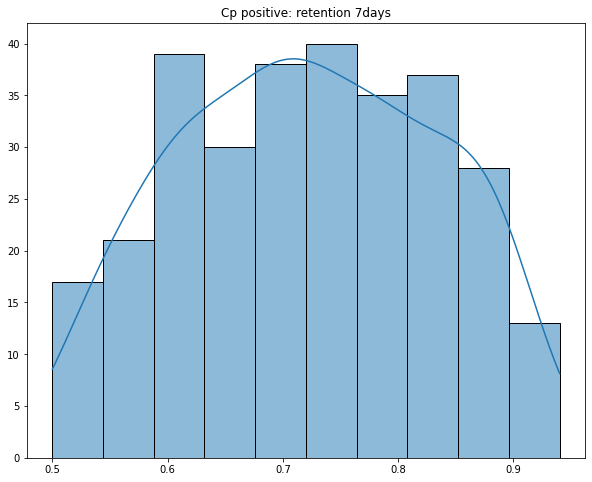

In [252]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches((10, 8))

fig1 = sns.histplot(cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True)
fig1.set(title = 'Cp positive: retention 7days', xlabel = '', ylabel = '')

- 7일 이내 재방문한 유저(이하 7 유저)의 이탈확률 분포는 가운데로 높이 솟은 형태로 보이며, 14일 이내 재방문한 유저(이하 14 유저)의 이탈확률 분포는 오른쪽으로 치우친 형태임.

7일

In [55]:
print('50%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6))]['memberId'].count()) *100, 2))
print('60%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7))]['memberId'].count()) *100, 2))
print('70%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8))]['memberId'].count()) *100, 2))
print('80%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9))]['memberId'].count()) *100, 2))
print('90%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1))]['memberId'].count()) *100, 2))

50%: 0.3
60%: 0.24
70%: 0.17
80%: 0.11
90%: 0.04


14일

In [61]:
print('50%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6))]['memberId'].count()) *100, 2))
print('60%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7))]['memberId'].count()) *100, 2))
print('70%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8))]['memberId'].count()) *100, 2))
print('80%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9))]['memberId'].count()) *100, 2))
print('90%:', round((cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()) / (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1))]['memberId'].count()) *100, 2))

50%: 0.79
60%: 0.66
70%: 0.64
80%: 0.5
90%: 0.21


- 비중 상으로는 이탈예측율이 높을 수록 방문율이 낮음.(큰 이슈가 없음) 그럼 실제 수치로 비교했을때는?

In [63]:
print('50%:', (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()), (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.5) & (cp_data['prob_churn_7days'] < 0.6)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()))
print('60%:', (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()), (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.6) & (cp_data['prob_churn_7days'] < 0.7)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()))
print('70%:', (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()), (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.7) & (cp_data['prob_churn_7days'] < 0.8)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()))
print('80%:', (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()), (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.8) & (cp_data['prob_churn_7days'] < 0.9)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()))
print('90%:', (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1)) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] ==1)]['memberId'].count()), (cp_data.loc[(cp_data['cp_subject'] ==  1) & ((cp_data['prob_churn_7days'] >= 0.9) & (cp_data['prob_churn_7days'] < 1)) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] ==1)]['memberId'].count()))

50%: 44 116
60%: 80 226
70%: 89 336
80%: 72 333
90%: 13 63


In [66]:
print(116+44)
print(226+80)
print(336+89)
print(333+72)
print(63+13)

160
306
425
405
76


In [65]:
print(116/44)
print(226/80)
print(336/89)
print(333/72)
print(63/13)

2.6363636363636362
2.825
3.7752808988764044
4.625
4.846153846153846


## 이탈율 분포: 캠페인 미반응 유저(재방문 7일)

- 미반응 유저는 14일 이내 방문 기준인 "캠페인 반응"이 없기 때문에 7일 내의 기간만 산정 가능

[Text(0.5, 1.0, 'Cp negative: retention 7days'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

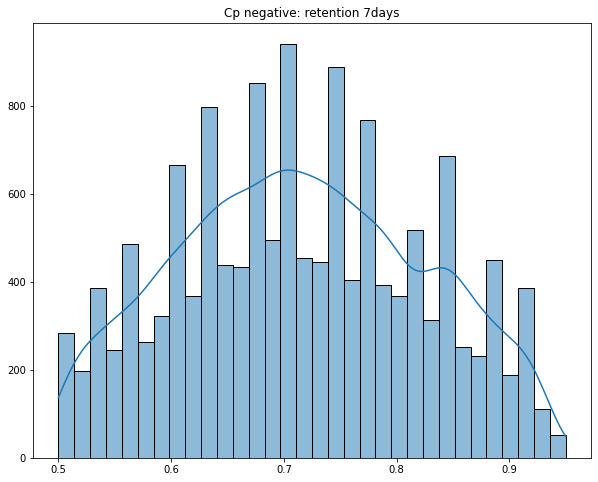

In [253]:
fig, axes = plt.subplots(1, 1)
fig.set_size_inches((10, 8))

fig1 = sns.histplot(cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 2)]['prob_churn_7days'] , kde = True)
fig1.set(title = 'Cp negative: retention 7days', xlabel = '', ylabel = '')

### 서비스별

Text(0.5, 1.0, 'Churn: retention 14days - Air Tour')

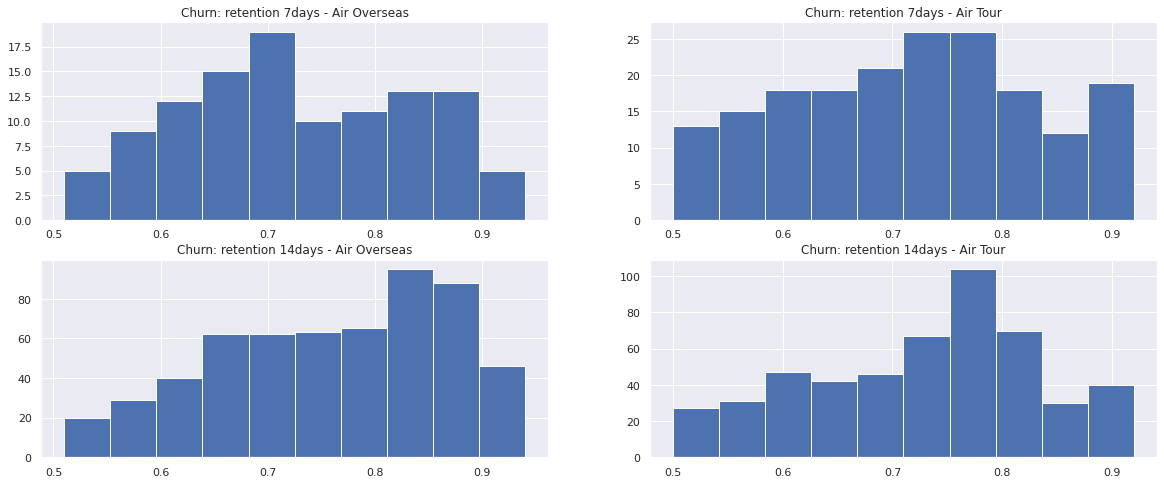

In [147]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((20, 8))

axes[0, 0].hist(cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[0, 0].set_title('Churn: retention 7days - Air Overseas')

axes[0, 1].hist(cp_data.loc[(cp_data['service'] == 2) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[0, 1].set_title('Churn: retention 7days - Air Tour')

axes[1, 0].hist(cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[1, 0].set_title('Churn: retention 14days - Air Overseas')

axes[1, 1].hist(cp_data.loc[(cp_data['service'] == 2) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'])
axes[1, 1].set_title('Churn: retention 14days - Air Tour')

[Text(0.5, 1.0, 'Cp positive: retention 14days - Tour Overseas'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

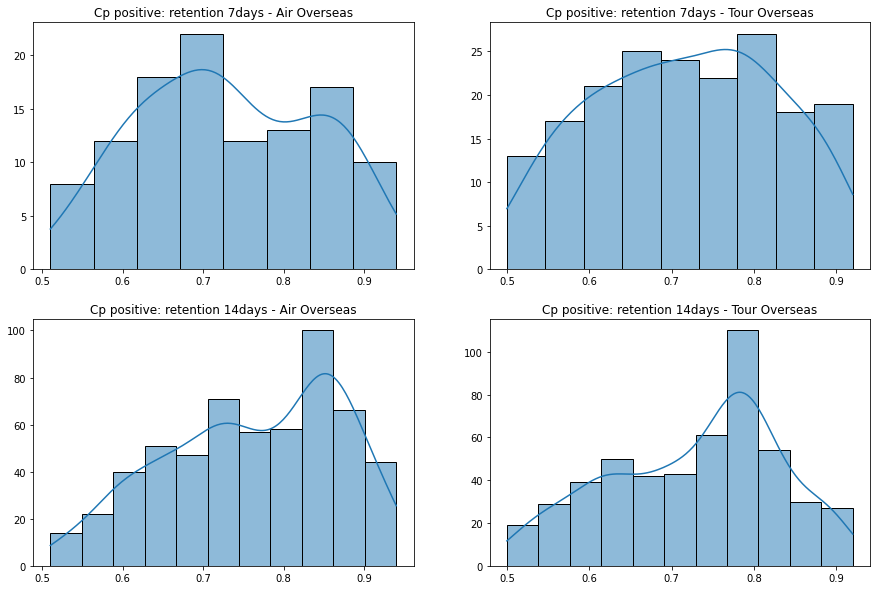

In [212]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((15, 10))

fig11 = sns.histplot(data = cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)], x = cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True, ax = axes[0, 0])
fig11.set(title = 'Cp positive: retention 7days - Air Overseas', xlabel = '', ylabel = '')
fig12 = sns.histplot(cp_data.loc[(cp_data['service'] == 2) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True, ax = axes[0, 1])
fig12.set(title = 'Cp positive: retention 7days - Tour Overseas', xlabel = '', ylabel = '')

fig21 = sns.histplot(cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 0])
fig21.set(title = 'Cp positive: retention 14days - Air Overseas', xlabel = '', ylabel = '')
fig22 = sns.histplot(cp_data.loc[(cp_data['service'] == 2) & (cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 1])
fig22.set(title = 'Cp positive: retention 14days - Tour Overseas', xlabel = '', ylabel = '')

[Text(0.5, 1.0, 'Cp positive: retention 14days - Tour Overseas'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

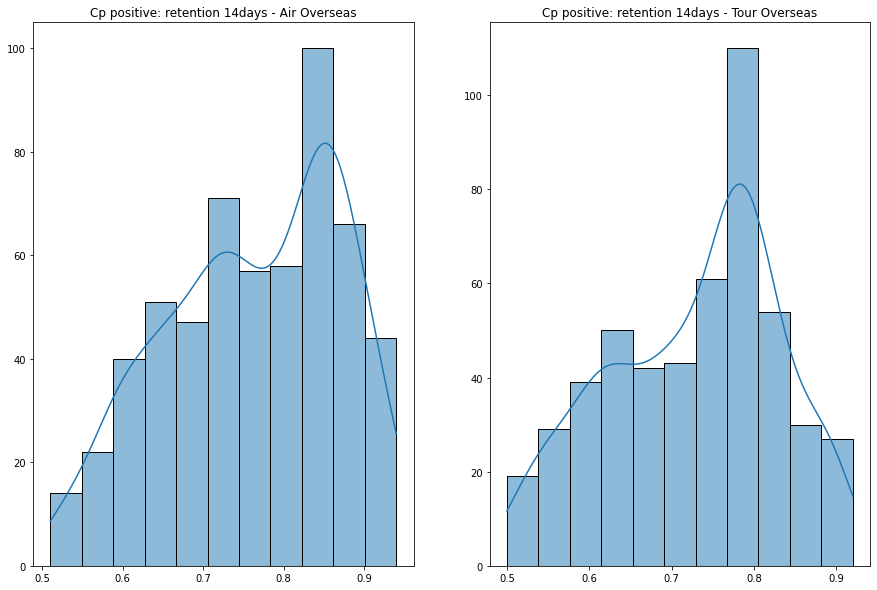

In [213]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches((15, 10))

fig21 = sns.histplot(cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[0])
fig21.set(title = 'Cp positive: retention 14days - Air Overseas', xlabel = '', ylabel = '')
fig22 = sns.histplot(cp_data.loc[(cp_data['service'] == 2) & (cp_data['prob_label'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1])
fig22.set(title = 'Cp positive: retention 14days - Tour Overseas', xlabel = '', ylabel = '')

- 조건이 두개라서 다봉분포 형태를 보이는 경우가 있음.

**(항공)**
- 기간을 늘릴 수록 그래프가 우측으로 쏠리는 형태를 보임 = 이탈확률이 높은 유저들이 재방문을 더 하고 있음.

**(여행)**
- 비교적 확률들이 고르게 분포되어있는 형태이나, 14 유저일 경우, 70% 후반대 ~ 80% 초 사이가 눈에 띄게 높아짐. 


=> (공통) 재방문 기간 범주를 늘릴 수록 이탈 확률이 높은 유저들이 재방문을 하고 있음

### 캠페인별

[Text(0.5, 1.0, 'Churn: retention 14days - Tour Overseas & cp_719'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

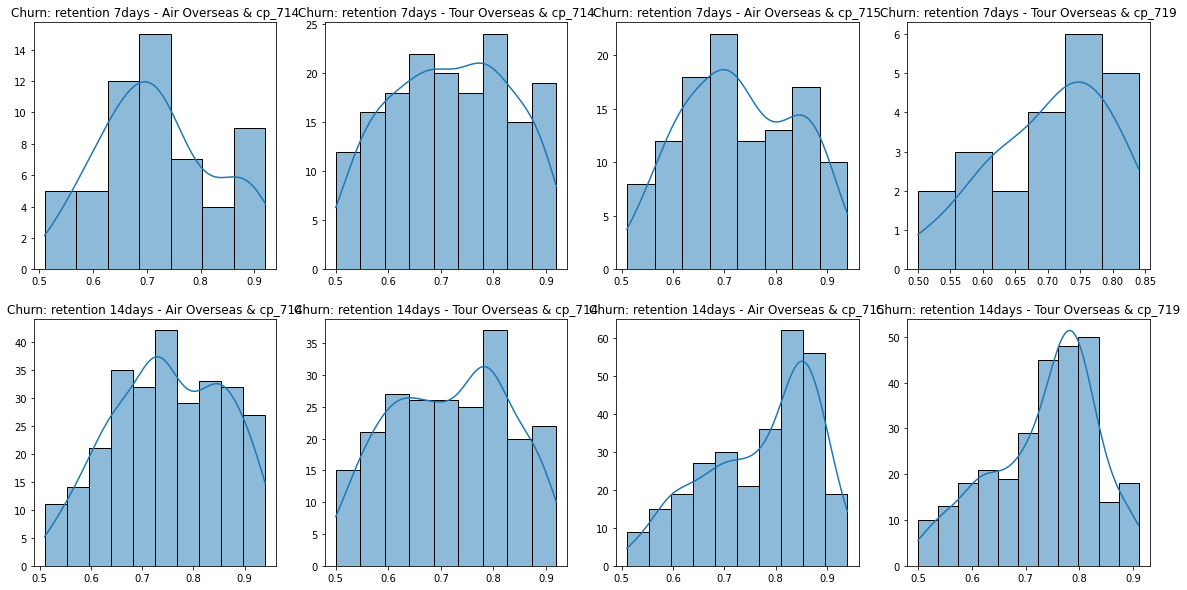

In [214]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches((20, 10))

fig11 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[0, 0])
fig11.set(title = 'Churn: retention 7days - Air Overseas & cp_714', xlabel = '', ylabel = '')
fig12 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 2) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[0, 1])
fig12.set(title = 'Churn: retention 7days - Tour Overseas & cp_714', xlabel = '', ylabel = '')
fig13 = sns.histplot(cp_data.loc[(cp_data['service'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True, ax = axes[0, 2])
fig13.set(title = 'Churn: retention 7days - Air Overseas & cp_715', xlabel = '', ylabel = '')
fig14 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 4) & (cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] ==  1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'] , kde = True, ax = axes[0, 3])
fig14.set(title = 'Churn: retention 7days - Tour Overseas & cp_719', xlabel = '', ylabel = '')

fig21 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 1) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 0])
fig21.set(title = 'Churn: retention 14days - Air Overseas & cp_714', xlabel = '', ylabel = '')
fig22 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 2) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 1])
fig22.set(title = 'Churn: retention 14days - Tour Overseas & cp_714', xlabel = '', ylabel = '')
fig23 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 3) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 2])
fig23.set(title = 'Churn: retention 14days - Air Overseas & cp_715', xlabel = '', ylabel = '')
fig24 = sns.histplot(cp_data.loc[(cp_data['cp_num'] == 4) & (cp_data['prob_label'] == 1) & (cp_data['cp_positive'] == 1)]['prob_churn_7days'], kde = True, ax = axes[1, 3])
fig24.set(title = 'Churn: retention 14days - Tour Overseas & cp_719', xlabel = '', ylabel = '')

- 7 유저는 비교적 완만한 곡선을 띄고 있는 것에 비해 14 유저는 우측으로 쏠리면서 특정 값이 두드러지는 형태가 보임.
- 거의 7~80% 단 유저들이 주요한 것으로 보임.(캠페인 by 캠페인이지만)

# 컬럼별 상관관계 분석

- 모델 변수이기 때문에 모델 결과치와 높은 상관관계를 가질 수 밖에 없음. 
- 이탈율 50% 이상 방문자(107746) / 캠페인 모수(197726) / 캠페인 모수 & 방문-반응O(298, 1074)/ 캠페인 모수 & 방문-반응X
- 위 대상별로 진행을 했으나, 특이점은 파악되지 않았음.

In [78]:
cp_data.columns

Index(['cp_date', 'service', 'cp_num', 'memberId', 'prob_churn_7days',
       'prob_label', 'is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click', 'cp_subject', 'cp_belong_to', 'cp_positive'],
      dtype='object')

- 이탈율 50% 이상 방문자

In [93]:
h_data = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['is_visit_next_7days'] == 1)]

In [95]:
h_data.shape

(107746, 19)

In [97]:
h_corr = h_data[['service', 'cp_num', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'total_page_clicks', 'cp_subject', 'cp_positive']]

<AxesSubplot:title={'center':'Correlation: ALL'}>

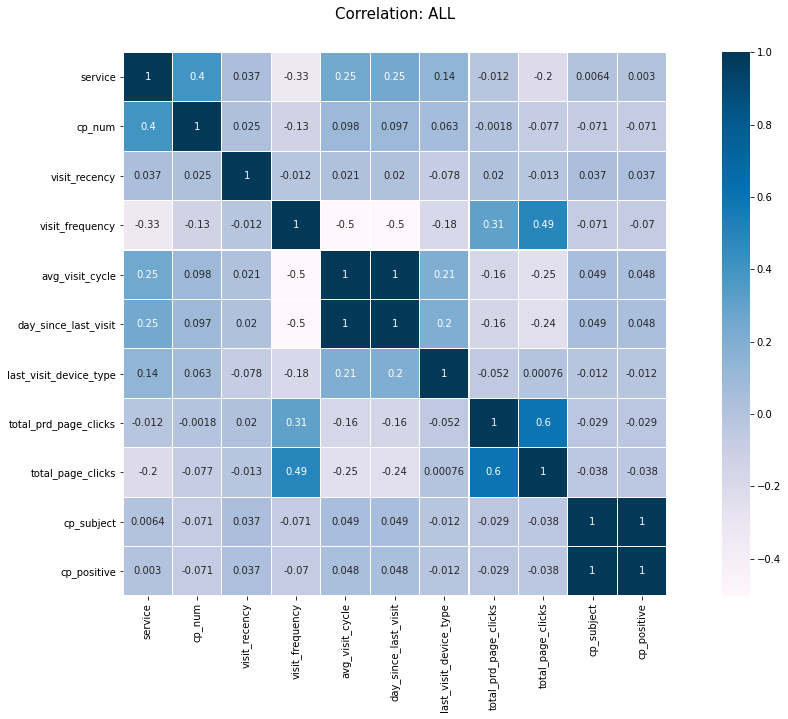

In [98]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 10))
plt.title("Correlation: ALL", y = 1.05, size = 15)
sns.heatmap(h_corr.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

- 캠페인 모수

In [102]:
h_data = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1)]

In [103]:
h_data.shape

(197726, 19)

In [104]:
h_corr = h_data[['service', 'cp_num', 'is_visit_next_7days', 'visit_recency', 'visit_frequency', 
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'total_page_clicks', 'cp_positive']]

<AxesSubplot:title={'center':'Correlation: cp population'}>

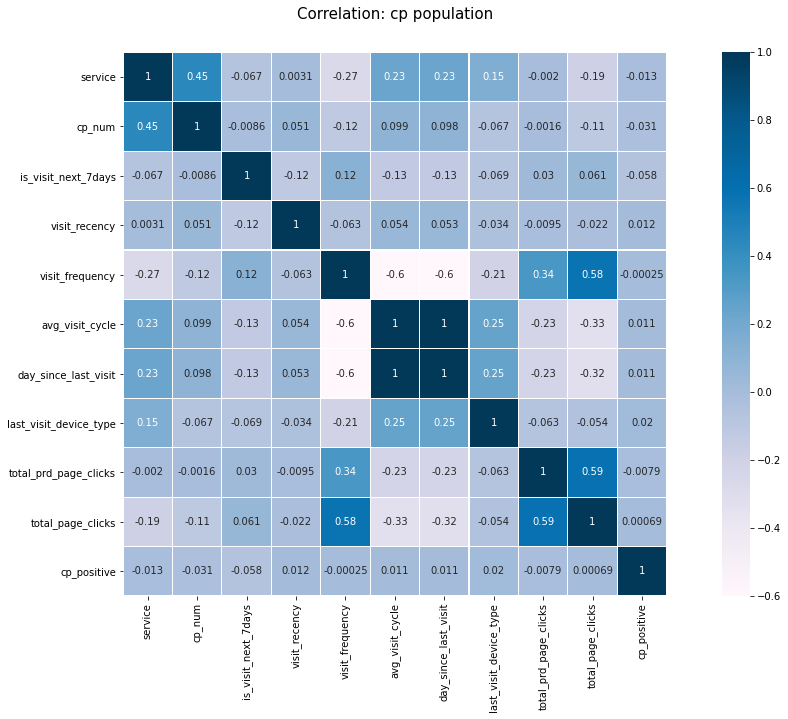

In [106]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 10))
plt.title("Correlation: cp population", y = 1.05, size = 15)
sns.heatmap(h_corr.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

- 캠페인 모수 & 방문-반응O(7일)

In [107]:
h_data = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 1)]

In [108]:
h_data.shape

(298, 19)

In [109]:
h_corr = h_data[['service', 'cp_num', 'visit_recency', 'visit_frequency', 
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'total_page_clicks']]

<AxesSubplot:title={'center':'Correlation: Visit for cp(7 days)'}>

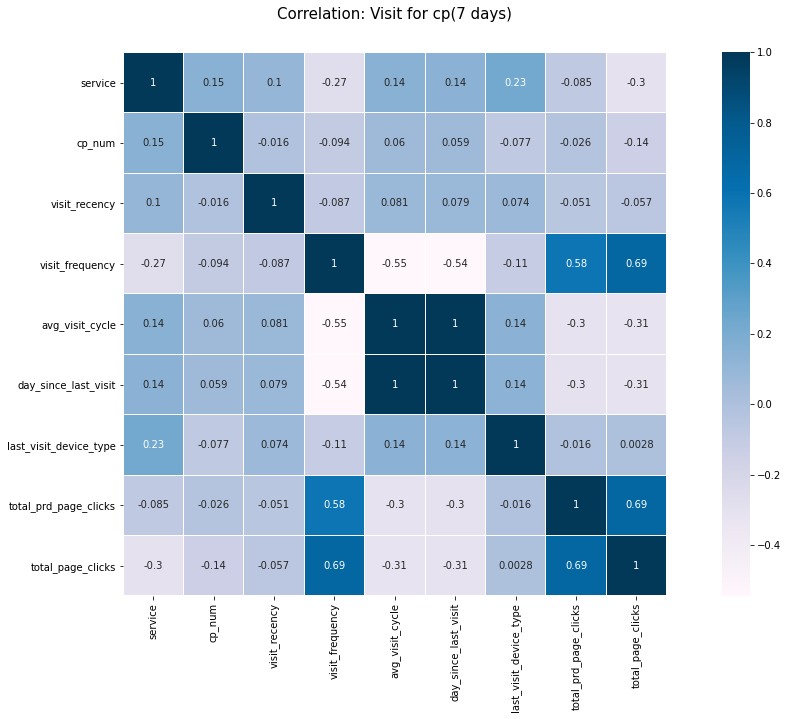

In [112]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 10))
plt.title("Correlation: Visit for cp(7 days)", y = 1.05, size = 15)
sns.heatmap(h_corr.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

- 캠페인 모수 & 방문-반응O(14일)

In [113]:
h_data = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & ((cp_data['is_visit_next_7days'] == 1)|(cp_data['cp_positive'] == 1)) & (cp_data['cp_positive'] == 1)]

In [114]:
h_data.shape

(1074, 19)

In [115]:
h_corr = h_data[['service', 'cp_num', 'visit_recency', 'visit_frequency', 
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'total_page_clicks']]

<AxesSubplot:title={'center':'Correlation: Visit for cp(14 days)'}>

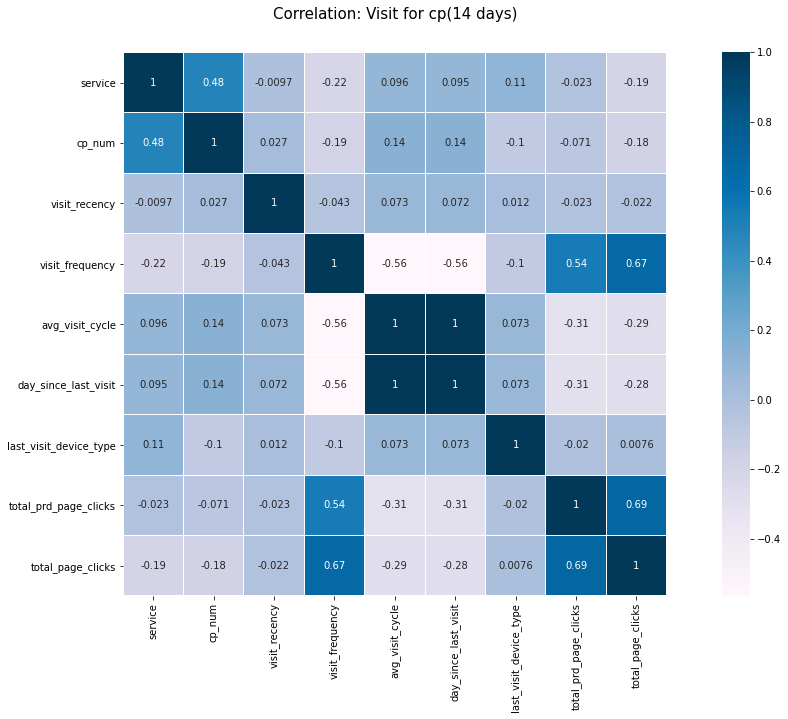

In [116]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 10))
plt.title("Correlation: Visit for cp(14 days)", y = 1.05, size = 15)
sns.heatmap(h_corr.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

- 캠페인 모수 & 반응X(7일): 1) 방문 자체를 안 한 유저 2) 방문은 했으나 캠페인으로 유입되지 않은 유저

In [135]:
h_data = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['cp_positive'] == 2)]

In [136]:
h_data.shape

(196652, 19)

In [137]:
h_corr = h_data[['service', 'cp_num', 'visit_recency', 'visit_frequency', 
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'total_page_clicks']]

<AxesSubplot:title={'center':'Correlation: No response(7 days)'}>

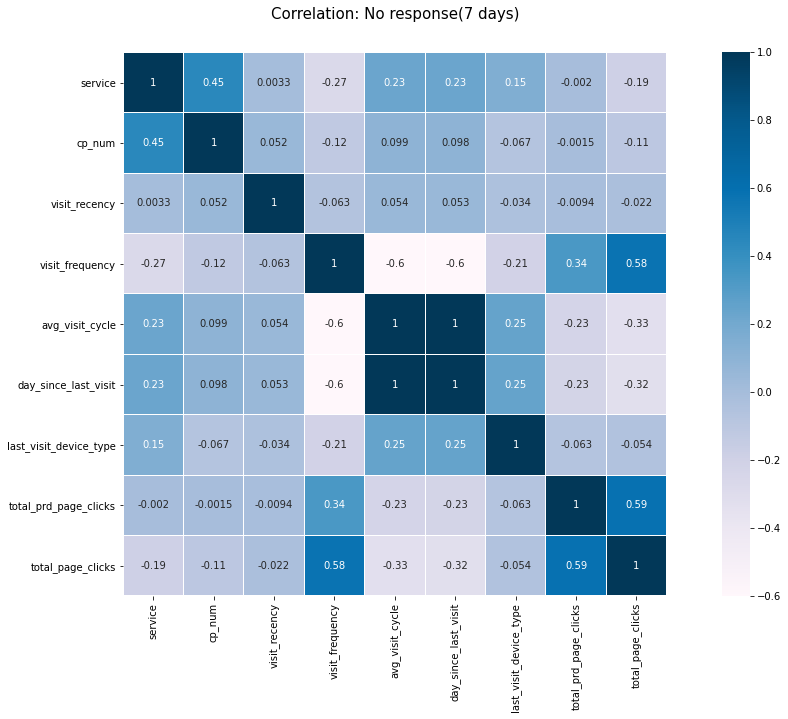

In [139]:
colormap = plt.cm.PuBu
plt.figure(figsize=(20, 10))
plt.title("Correlation: No response(7 days)", y = 1.05, size = 15)
sns.heatmap(h_corr.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

## 유저별 특성 파악

- 캠페인 모수, 캠페인 반응 유저, 캠페인 미반응 유저의 컬럼 확인 후 비교(7d일 기준)

In [151]:
cp_pop = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1)]
resp_user = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 1)]
no_resp_user = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['cp_positive'] == 2)]

In [143]:
cp_pop.columns

Index(['cp_date', 'service', 'cp_num', 'memberId', 'prob_churn_7days',
       'prob_label', 'is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit', 'last_visit_device_type',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click', 'cp_subject', 'cp_belong_to', 'cp_positive'],
      dtype='object')

- 전체 유저 수
- 평균 미방문일자(현재날짜 - 마지막 방문 = 미방문일자) (현재 날짜 - 마지막 방문, 클 수록 안 좋음)
- 평균 방문 빈도(적은 게 좋음)
- 평균 방문 주기(2번 이상 방문 유저 한정, 적은 게 좋음)
- 전체 상품상세 페이지 클릭 수(방문빈도와 관계없이 계산된 것이기 때문에 평균을 더 보는 게 좋을 듯)
- (유저별) 평균 상품상세 페이지 클릭 수
- 전체 페이지 클릭 수(방문빈도와 관계없이 계산된 것이기 때문에 평균을 더 보는 게 좋을 듯)
- (유저별) 평균 페이지 클릭 수

In [148]:
cp_pop[['prob_churn_7days','is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click']].describe().T

,count,mean,std,min,25%,50%,75%,max
prob_churn_7days,197726.0,0.775680,0.109734,0.5,0.7,0.79,0.87,0.96
is_visit_next_7days,197726.0,0.072656,0.259572,0.0,0.0,0.00,0.00,1.00
visit_recency,197726.0,27.197885,18.450320,0.0,10.0,25.00,43.00,65.00
visit_frequency,197726.0,2.710559,2.933771,1.0,1.0,1.00,3.00,100.00
avg_visit_cycle,197726.0,518.814104,488.386856,1.0,15.0,999.00,999.00,999.00
day_since_last_visit,197726.0,519.708834,487.594059,1.0,14.0,999.00,999.00,999.00
total_prd_page_clicks,197726.0,2.488342,7.248947,0.0,0.0,0.00,2.00,430.00
avg_prd_page_click,197726.0,0.932037,2.004329,0.0,0.0,0.00,1.00,85.00
total_page_clicks,197726.0,11.210180,25.424913,0.0,1.0,4.00,10.00,1556.00
avg_page_click,197726.0,3.649508,5.485239,0.0,1.0,2.00,4.00,296.00


In [149]:
resp_user[['prob_churn_7days','is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click']].describe().T

,count,mean,std,min,25%,50%,75%,max
prob_churn_7days,298.0,0.721611,0.110247,0.500,0.63,0.72,0.81000,0.94
is_visit_next_7days,298.0,1.000000,0.000000,1.000,1.00,1.00,1.00000,1.00
visit_recency,298.0,21.124161,17.517707,0.000,5.00,15.00,36.00000,60.00
visit_frequency,298.0,2.828859,2.474293,1.000,1.00,2.00,4.00000,22.00
avg_visit_cycle,298.0,360.923826,464.911278,1.000,14.00,32.35,999.00000,999.00
day_since_last_visit,298.0,363.120805,463.530870,1.000,12.00,39.00,999.00000,999.00
total_prd_page_clicks,298.0,3.865772,6.236806,0.000,0.00,2.00,4.00000,51.00
avg_prd_page_click,298.0,1.336678,1.688036,0.000,0.00,1.00,1.66700,12.00
total_page_clicks,298.0,11.261745,20.066857,1.000,2.00,4.00,12.00000,150.00
avg_page_click,298.0,3.453758,4.220412,0.667,1.00,2.00,3.70225,38.00


In [152]:
no_resp_user[['prob_churn_7days','is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click']].describe().T

,count,mean,std,min,25%,50%,75%,max
prob_churn_7days,196652.0,0.775844,0.109723,0.5,0.7,0.79,0.87,0.96
is_visit_next_7days,196652.0,0.071538,0.257721,0.0,0.0,0.00,0.00,1.00
visit_recency,196652.0,27.213591,18.445495,0.0,10.0,25.00,43.00,65.00
visit_frequency,196652.0,2.710504,2.934907,1.0,1.0,1.00,3.00,100.00
avg_visit_cycle,196652.0,519.197386,488.392516,1.0,15.0,999.00,999.00,999.00
day_since_last_visit,196652.0,520.092737,487.598262,1.0,14.0,999.00,999.00,999.00
total_prd_page_clicks,196652.0,2.484104,7.253645,0.0,0.0,0.00,2.00,430.00
avg_prd_page_click,196652.0,0.930668,2.005096,0.0,0.0,0.00,1.00,85.00
total_page_clicks,196652.0,11.211475,25.422355,0.0,1.0,4.00,10.00,1556.00
avg_page_click,196652.0,3.650974,5.490289,0.0,1.0,2.00,4.00,296.00


- 미반응 유저 분류: 1) 아예 방문 조차 하지 않음. 2) 방문은 했으나 캠페인으로 유입되지 않음

In [153]:
no_resp_user_nv = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 0) & (cp_data['cp_positive'] == 2)]
no_resp_user_yv = cp_data.loc[(cp_data['prob_label'] == 1) & (cp_data['cp_subject'] == 1) & (cp_data['is_visit_next_7days'] == 1) & (cp_data['cp_positive'] == 2)]

In [155]:
no_resp_user_nv[['prob_churn_7days','is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click']].describe().T

,count,mean,std,min,25%,50%,75%,max
prob_churn_7days,182584.0,0.780553,0.108409,0.5,0.7,0.8,0.87,0.96
is_visit_next_7days,182584.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
visit_recency,182584.0,27.808390,18.414188,0.0,11.0,29.0,43.00,65.00
visit_frequency,182584.0,2.614117,2.854411,1.0,1.0,1.0,3.00,100.00
avg_visit_cycle,182584.0,536.271783,487.766838,1.0,16.0,999.0,999.00,999.00
day_since_last_visit,182584.0,537.155682,486.946669,1.0,15.0,999.0,999.00,999.00
total_prd_page_clicks,182584.0,2.424583,7.067263,0.0,0.0,0.0,2.00,340.00
avg_prd_page_click,182584.0,0.936182,2.012621,0.0,0.0,0.0,1.00,85.00
total_page_clicks,182584.0,10.779072,24.698705,0.0,1.0,3.0,10.00,1556.00
avg_page_click,182584.0,3.609724,5.349602,0.0,1.0,2.0,4.00,197.00


In [154]:
no_resp_user_yv[['prob_churn_7days','is_visit_next_7days', 'visit_recency', 'visit_frequency',
       'avg_visit_cycle', 'day_since_last_visit',
       'total_prd_page_clicks', 'avg_prd_page_click', 'total_page_clicks',
       'avg_page_click']].describe().T

,count,mean,std,min,25%,50%,75%,max
prob_churn_7days,14068.0,0.714719,0.108332,0.5,0.63,0.71,0.8,0.95
is_visit_next_7days,14068.0,1.000000,0.000000,1.0,1.00,1.00,1.0,1.00
visit_recency,14068.0,19.493887,17.060134,0.0,5.00,14.00,33.0,65.00
visit_frequency,14068.0,3.961473,3.602416,1.0,1.00,3.00,5.0,40.00
avg_visit_cycle,14068.0,297.594335,439.972943,1.0,10.70,24.50,999.0,999.00
day_since_last_visit,14068.0,298.638328,439.529955,1.0,6.00,28.00,999.0,999.00
total_prd_page_clicks,14068.0,3.256611,9.307033,0.0,0.00,0.00,3.0,430.00
avg_prd_page_click,14068.0,0.859095,1.903363,0.0,0.00,0.00,1.0,43.00
total_page_clicks,14068.0,16.823500,32.911801,0.0,3.00,7.00,17.0,812.00
avg_page_click,14068.0,4.186347,7.044915,0.0,1.25,2.00,4.0,296.00
